<a href="https://colab.research.google.com/github/ritikpathania/project/blob/main/densenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import zipfile

zip_path = '/content/drive/MyDrive/archive.zip'  # Specify the path to the zip file
output_path = '/content/dataset'                # Specify the path to extract the dataset

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(output_path)

In [7]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc

In [4]:
# Create a DenseNet121 model
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers on top of the pre-trained DenseNet model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(2, activation='softmax')(x)

# Final model
model = Model(inputs=base_model.input, outputs=predictions)

# Unfreeze the last few layers for fine-tuning
for layer in base_model.layers[-20:]:
    layer.trainable = True

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Define data generators for train, validation, and test data
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=20, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Data generators for train, validation, and test datasets
train_generator = train_datagen.flow_from_directory(
    '/content/dataset/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical')

val_generator = val_datagen.flow_from_directory(
    '/content/dataset/data',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    '/content/dataset/test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False)

# Train the model with increased epochs
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // 32,
    epochs=20,  # Increase epochs
    validation_data=val_generator,
    validation_steps=val_generator.samples // 32)

29084464/29084464 [==============================] - 0s 0us/step
Found 2637 images belonging to 2 classes.
Found 3297 images belonging to 2 classes.
Found 660 images belonging to 2 classes.
Epoch 1/20
82/82 [==============================] - 153s 845ms/step - loss: 0.4611 - accuracy: 0.7916 - val_loss: 2.5973 - val_accuracy: 0.2336
Epoch 2/20
82/82 [==============================] - 63s 765ms/step - loss: 0.3029 - accuracy: 0.8622 - val_loss: 3.5944 - val_accuracy: 0.2992
Epoch 3/20
82/82 [==============================] - 63s 761ms/step - loss: 0.2379 - accuracy: 0.8921 - val_loss: 3.8892 - val_accuracy: 0.3010
Epoch 4/20
82/82 [==============================] - 61s 739ms/step - loss: 0.2170 - accuracy: 0.9033 - val_loss: 3.2917 - val_accuracy: 0.3950
Epoch 5/20
82/82 [==============================] - 62s 747ms/step - loss: 0.1725 - accuracy: 0.9240 - val_loss: 4.3216 - val_accuracy: 0.4521
Epoch 6/20
82/82 [==============================] - 71s 868ms/step - loss: 0.1814 - accuracy: 

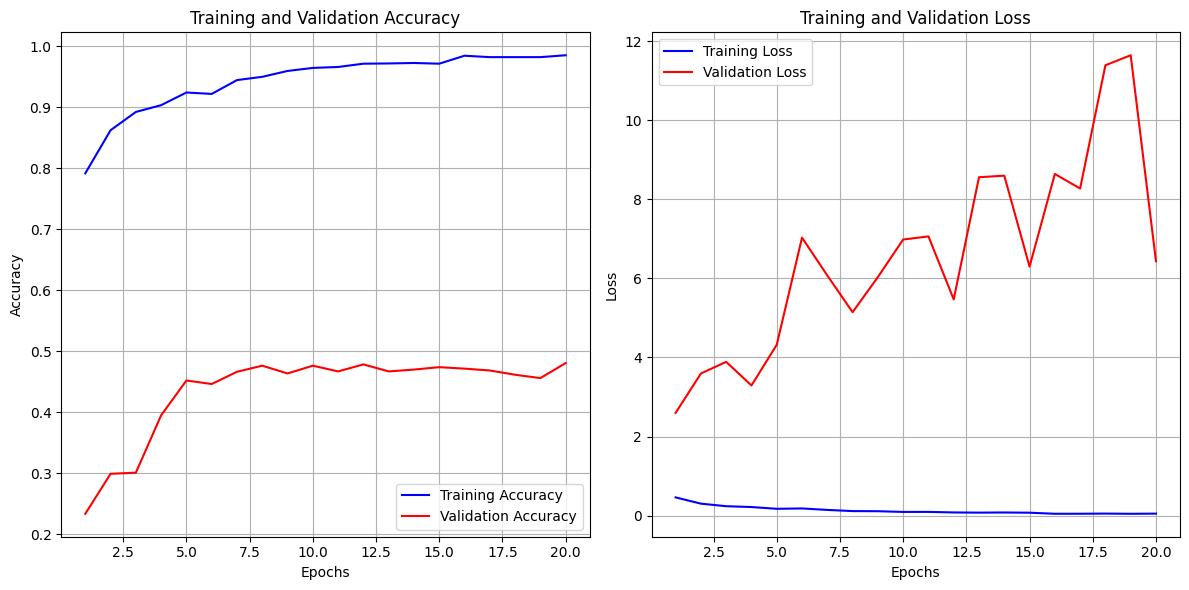

21/21 [==============================] - 2s 106ms/step - loss: 0.4522 - accuracy: 0.8727
Test Accuracy: 0.8727272748947144
21/21 [==============================] - 3s 152ms/step


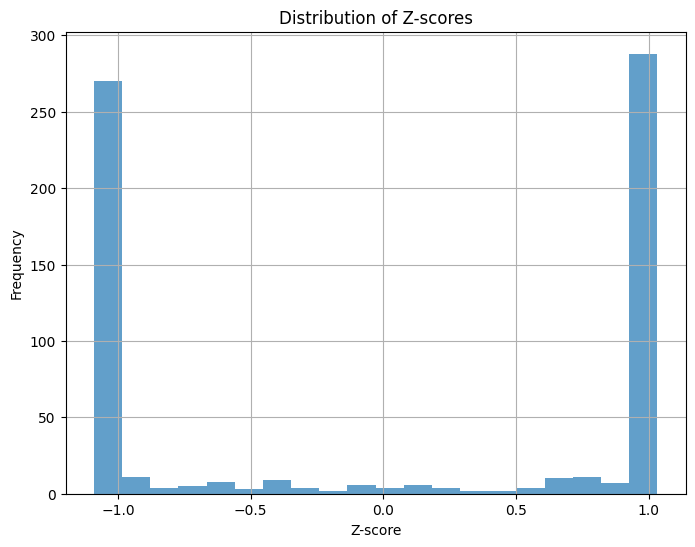

Confusion Matrix:
[[299  61]
 [ 23 277]]
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.83      0.88       360
           1       0.82      0.92      0.87       300

    accuracy                           0.87       660
   macro avg       0.87      0.88      0.87       660
weighted avg       0.88      0.87      0.87       660

Classification Report:
               precision    recall  f1-score     support
Class 0        0.928571  0.830556  0.876833  360.000000
Class 1        0.819527  0.923333  0.868339  300.000000
accuracy       0.872727  0.872727  0.872727    0.872727
macro avg      0.874049  0.876944  0.872586  660.000000
weighted avg   0.879006  0.872727  0.872972  660.000000
AUC-ROC: 0.9644583333333334


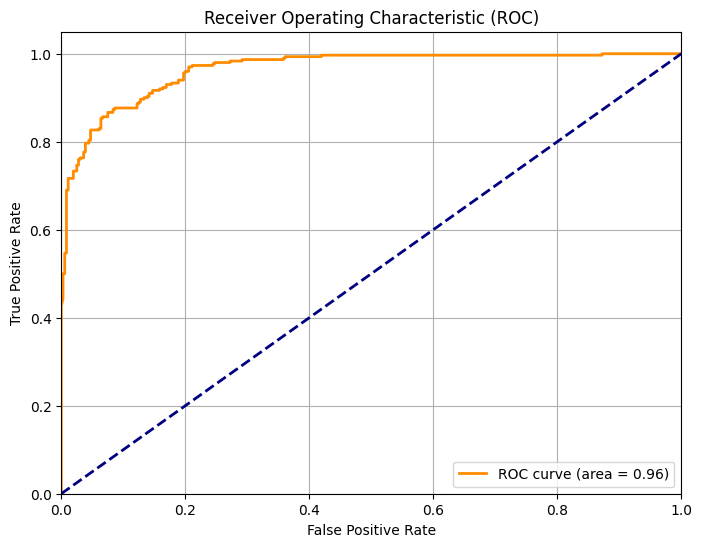

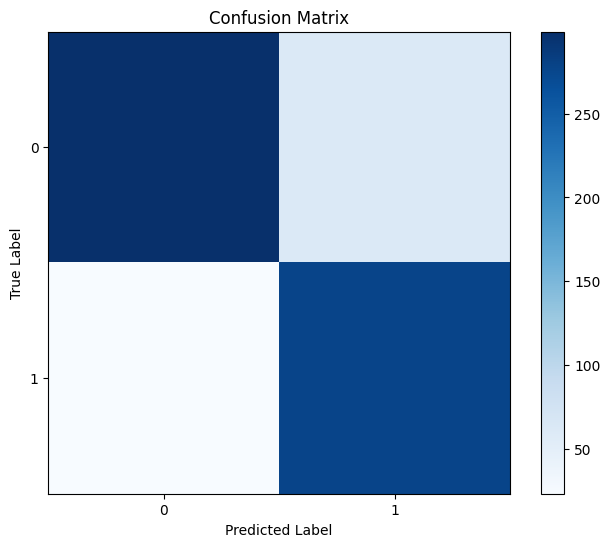

In [8]:
# Extract accuracy and validation accuracy from the history
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(accuracy) + 1)

# Plot training and validation accuracy
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy}")

# Predict probabilities for the test set
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

# Get true labels
true_classes = test_generator.classes

# Get class probabilities
class_probabilities = predictions[:, 1]  # Assuming the positive class is at index 1

# Calculate z-scores for class_probabilities
mean_prob = np.mean(class_probabilities)
std_dev_prob = np.std(class_probabilities)
z_scores = (class_probabilities - mean_prob) / std_dev_prob

# Plot z-scores
plt.figure(figsize=(8, 6))
plt.hist(z_scores, bins=20, alpha=0.7)
plt.xlabel('Z-score')
plt.ylabel('Frequency')
plt.title('Distribution of Z-scores')
plt.grid()
plt.show()

# Calculate confusion matrix
confusion_mtx = confusion_matrix(true_classes, predicted_classes)
print("Confusion Matrix:")
print(confusion_mtx)

# Print classification report
print("Classification Report:")
print(classification_report(true_classes, predicted_classes))

# Calculate AUC-ROC
fpr, tpr, thresholds = roc_curve(true_classes, class_probabilities)
roc_auc = auc(fpr, tpr)
print(f"AUC-ROC: {roc_auc}")

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(confusion_mtx, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(np.unique(true_classes)))
plt.xticks(tick_marks, range(len(np.unique(true_classes))))
plt.yticks(tick_marks, range(len(np.unique(true_classes))))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()